<a href="https://colab.research.google.com/github/amanjain252002/Implementation-of-Word2vec-and-GloVe/blob/main/GloVe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from tqdm.notebook import tqdm

import nltk
nltk.download('punkt')

import tensorflow as tf
print(tf.__version__)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
2.4.1


## Data Preprocessing

In [2]:
with open("/content/Database.txt", errors = 'ignore') as f:
  Data = f.read()

In [3]:
# Converts data to lowercase
Data = Data.lower()
# Removes numbers from the data
Data = re.sub(r'[0-9]+', '', Data)
# Removes special characters from the data
Data = re.sub(r'[^A-Za-z0-9 ]+', '', Data)

Tokenization is the process by which a large quantity of text is divided into smaller parts called tokens. These tokens are very useful for finding patterns and are considered as a base step for stemming and lemmatization. Tokenization also helps to substitute sensitive data elements with non-sensitive data elements.

In [4]:
words = nltk.word_tokenize(Data)

In [5]:
# Generates word_to_index and index_to_word dictionary
word_to_index = {}
index_to_word = {}
count = 0
for word in words:
  if(word not in word_to_index.keys()):
    word_to_index[word] = count
    count = count + 1
for word in word_to_index.keys():
  index_to_word[word_to_index[word]] = word

In [6]:
# Generate a co-occurence matrix
def cooccurence_matrix(words, word_to_index, window_size):
  V = len(word_to_index)
  matrix = np.zeros(shape = (V, V))
  for i in tqdm(range(len(words))):
    for j in range(i - window_size, i + window_size + 1, 1):
      if(j < 0 or j == i or j > (len(words) - 1)):
        continue
      increment = 1.0/(abs(i - j))
      matrix[word_to_index[words[i]]][word_to_index[words[j]]] = matrix[word_to_index[words[i]]][word_to_index[words[j]]] + increment
  return matrix

In [7]:
matrix = cooccurence_matrix(words, word_to_index, 10)

## Modeling

In [8]:
# Random normal weights intialization
def Weight_Intialization(V, n_Hidden):
  W1 = np.random.randn(V, n_Hidden)
  b1 = np.random.randn(V, 1)
  W2 = np.random.randn(V, n_Hidden)
  b2 = np.random.randn(V, 1)
  return W1, b1, W2, b2

In [9]:
# Back Propagation
def back_prop(W1, b1, W2, b2, x, x_max, V, learning_rate):
  global_cost = 0
  for i in range(V):
    for j in range(V):
      weight = ((x[i][j]/x_max)**2 if(x[i][j] < x_max) else 1)
      cost_inner = np.dot(W1[i], W2[j]) + b1[i] + b2[j] - (np.log(x[i][j]) if(x[i][j] != 0) else 0)
      cost = weight*(cost_inner**2)
      global_cost = global_cost + cost

      dW1 = weight*cost_inner*W2[j]
      dW2 = weight*cost_inner*W1[i]
      db1 = weight*cost_inner
      db2 = weight*cost_inner

      W1[i] = W1[i] - learning_rate*dW1
      W2[j] = W2[j] - learning_rate*dW2
      b1[i] = b1[i] - learning_rate*db1
      b2[j] = b2[j] - learning_rate*db2

  return W1, b1, W2, b2, global_cost  

In [10]:
# Model
def GloVe(x, word_to_index, epochs = 10, learning_rate = 0.0001, x_max = 10):
  V = len(word_to_index)
  n_Hidden = 300
  W1, b1, W2, b2 = Weight_Intialization(V, n_Hidden)
  for i in tqdm(range(epochs)):
    W1, b1, W2, b2, global_cost = back_prop(W1, b1, W2, b2, x, x_max, V, learning_rate)
  return W1, W2 

In [11]:
W1, W2 = GloVe(matrix, word_to_index, 10, 0.00001)

In [12]:
W = np.add(W1, W2)/2

In [13]:
W = W.T

In [14]:
# Generates word to word embedding dictionary
word_to_vector = {}
for word in word_to_index.keys():
  word_to_vector[word] = W[:, word_to_index[word]]

## Principal component analysis

Word Embeddings has 300 dimensions, so to visualise, we used PCA to reduce it into 2 dimensions.

In [15]:
pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(W.T)

In [16]:
word_to_reduce_vector = {}
for word in word_to_index.keys():
  word_to_reduce_vector[word] = principalComponents[word_to_index[word], :]

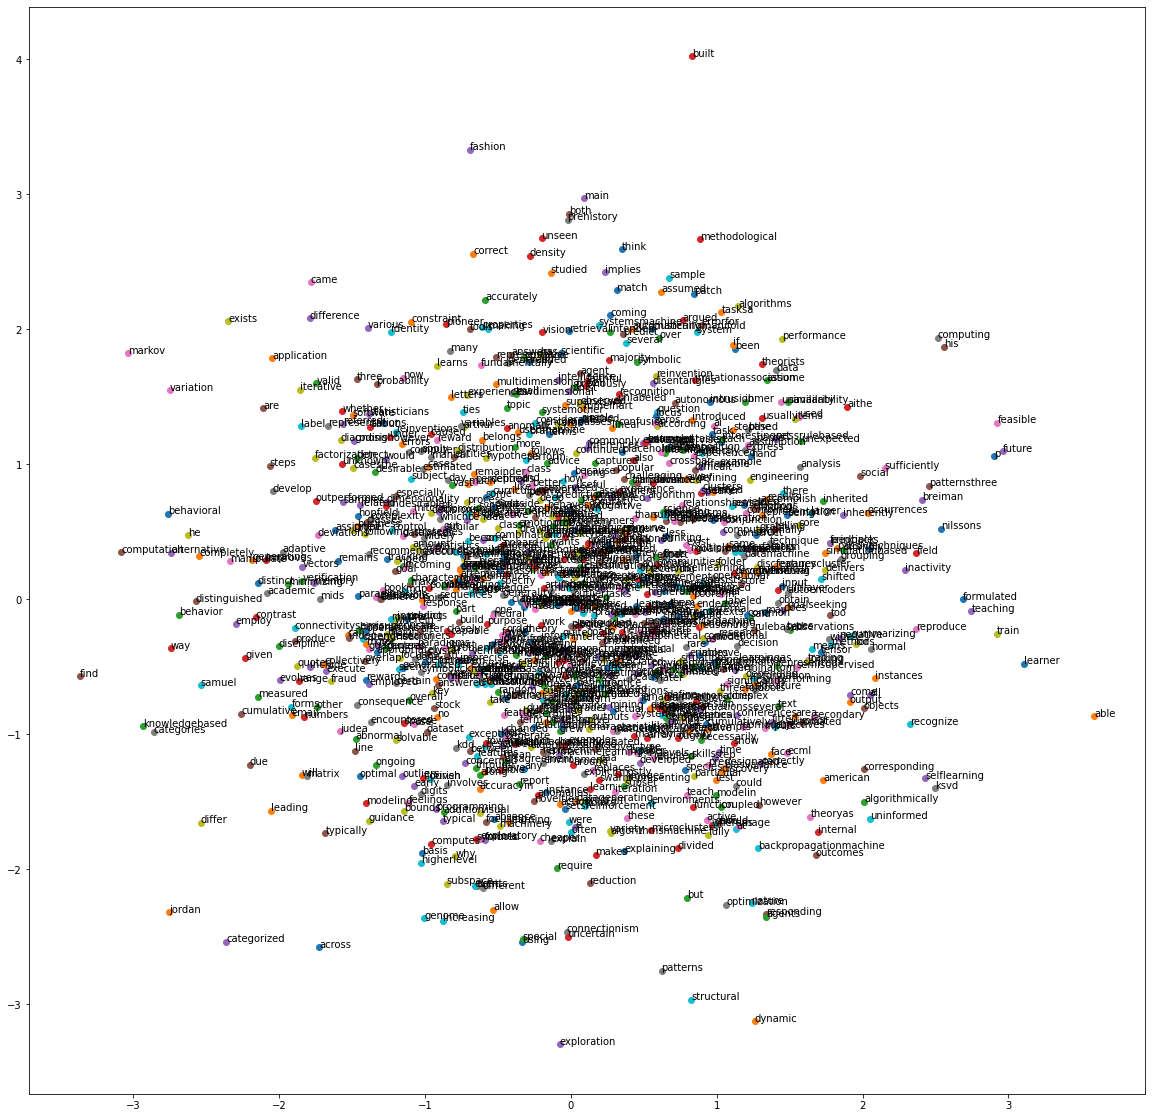

In [17]:
plt.figure(figsize = (20, 20))
for word, vector in word_to_reduce_vector.items():
  plt.scatter(vector[0], vector[1])
  plt.annotate(word, (vector[0], vector[1]))